In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
file_path = 'D:\Infosys springboard\churn_data\Churn_ Data.csv'  
data = pd.read_csv(file_path)

In [3]:
# Display the first few rows of the dataset
print("First few rows of the dataset:")
print(data.head())



First few rows of the dataset:
   s6.new.rev.p2.m2  s1.new.rev.m1  s3.og.rev.4db.p5  s3.new.rev.4db.p5  \
0             -0.76        88.0482          3.106604           3.754955   
1             -0.98        67.5039          3.094574           5.550865   
2             -0.98        33.9248          2.324016           2.438114   
3             -0.92        82.6780          2.630749           2.858961   
4             -0.97        96.8379          2.674316           2.912397   

   s4.usg.ins.p2  s4.og.unq.any.p2  s2.rch.val.p6  s1.og.rev.all.m1  \
0              4                14          39.29            57.320   
1              1                 2          21.67            38.700   
2              2                 3          30.00            15.320   
3              2                 3          50.00            51.956   
4              3                 2          22.50            66.886   

   s8.new.rev.p6  s4.loc.ic.ins.p1  ...  prop.og.mou.tot.mou.all.p6  \
0          -0.17    

In [4]:
# Summary of the dataset
print("\nSummary of the dataset:")
print(data.info())




Summary of the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Columns: 111 entries, s6.new.rev.p2.m2 to s3.rev.p1
dtypes: float64(80), int64(31)
memory usage: 21.2 MB
None


In [5]:
# Basic statistics of the dataset
print("\nBasic statistics of the dataset:")
print(data.describe())


Basic statistics of the dataset:


       s6.new.rev.p2.m2  s1.new.rev.m1  s3.og.rev.4db.p5  s3.new.rev.4db.p5  \
count      25000.000000   25000.000000      25000.000000       25000.000000   
mean          -0.003730     281.073083          4.890003           7.070194   
std            2.727916     276.075983          4.212452           6.318992   
min           -1.000000       0.000000          0.000000           0.000833   
25%           -0.580000     101.563800          2.367288           3.318825   
50%           -0.170000     204.859600          3.729944           5.231268   
75%            0.280000     370.711650          5.993342           8.395736   
max          316.860000    5702.924300        153.221695         170.200441   

       s4.usg.ins.p2  s4.og.unq.any.p2  s2.rch.val.p6  s1.og.rev.all.m1  \
count   25000.000000      25000.000000   25000.000000      25000.000000   
mean        5.460080         28.532520      72.208906        218.517937   
std         2.184444         28.061435      67.921490        23

In [6]:
for col in data.columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')
data.shape


(25000, 111)

In [7]:
# Step 2: Remove Duplicate Records
data = data.drop_duplicates()
data.shape

(25000, 111)

In [8]:
# Step 3: Remove Unique Value Variables
unique_counts = data.nunique()
cols_to_drop = unique_counts[unique_counts == len(data)].index
data = data.drop(cols_to_drop, axis=1)

In [9]:
# Step 4: Remove Zero Variance Variables
var_thresh = VarianceThreshold(threshold=0)
var_thresh.fit(data)
zero_variance_cols = data.columns[~var_thresh.get_support()]
data = data.drop(zero_variance_cols, axis=1)


In [10]:
# Step 5: Outlier Treatment

# Using Boxplot Method
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
data = data.clip(lower=(Q1 - 1.5 * IQR), upper=(Q3 + 1.5 * IQR), axis=1)


In [11]:
# Standardization Method (3-sigma approach)
scaler = StandardScaler()
z_scores = np.abs(scaler.fit_transform(data.select_dtypes(include=[np.number])))
data[(z_scores > 3).any(axis=1)] = np.nan
data.shape

(25000, 111)

In [13]:

# Step 1: Analyze the missing values
def analyze_missing_values(df):
    missing_data = df.isnull().sum().sort_values(ascending=False)
    missing_percentage = (df.isnull().sum() / df.isnull().count() * 100).sort_values(ascending=False)
    missing_df = pd.concat([missing_data, missing_percentage], axis=1, keys=['Total', 'Percentage'])
    return missing_df

# Display the initial missing values analysis
initial_missing_values = analyze_missing_values(data)
print("Initial Missing Values Analysis:")
print(initial_missing_values)

# Step 2: Remove records with more than 5% missing values
threshold = data.shape[1] * 0.95
data = data.dropna(thresh=int(threshold))

print(f"Cleaned data shape: {data.shape}")


Initial Missing Values Analysis:
                       Total  Percentage
s6.new.rev.p2.m2         651       2.604
s8.rtd.mou.p3            651       2.604
s8.og.mou.all.p6         651       2.604
s7.s5.s4.day.nomou.p2    651       2.604
s3.rtd.mou.p1            651       2.604
...                      ...         ...
s3.og.mou.all.p1         651       2.604
snd.dec.p2               651       2.604
ds.usg.p6                651       2.604
s7.new.rev.p3.p6         651       2.604
s3.rev.p1                651       2.604

[111 rows x 2 columns]
Cleaned data shape: (24349, 111)


In [14]:
# Step 2: Remove columns with more than 50% missing values
threshold = data.shape[0] * 0.5
data = data.loc[:, data.isnull().sum() <= threshold]
print(f"Cleaned data shape: {data.shape}")

Cleaned data shape: (24349, 111)


In [15]:
from sklearn.impute import KNNImputer

# Step 1: Analyze the data types
def analyze_data_types(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    return numeric_cols, categorical_cols

numeric_cols, categorical_cols = analyze_data_types(data)
print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)
# Step 2: Encode categorical columns before KNN imputation
data_encoded = data.copy()
for col in categorical_cols:
    data_encoded[col] = data_encoded[col].astype('category').cat.codes

"""K-Nearest Neighbors (KNN) imputation is a method used to fill in missing values in a dataset
 by leveraging the information from the 'nearest' observations."""

# Step 3: KNN Imputation
knn_imputer = KNNImputer(n_neighbors=5)
data_imputed = knn_imputer.fit_transform(data_encoded)

# Convert back to DataFrame
data_imputed = pd.DataFrame(data_imputed, columns=data.columns)

# Decode categorical columns after imputation
for col in categorical_cols:
    data_imputed[col] = data_imputed[col].round().astype(int).astype('category')
    data_imputed[col] = data_imputed[col].cat.rename_categories(data[col].astype('category').cat.categories)

data = data_imputed.copy()


Numeric columns: ['s6.new.rev.p2.m2', 's1.new.rev.m1', 's3.og.rev.4db.p5', 's3.new.rev.4db.p5', 's4.usg.ins.p2', 's4.og.unq.any.p2', 's2.rch.val.p6', 's1.og.rev.all.m1', 's8.new.rev.p6', 's4.loc.ic.ins.p1', 's8.mbl.p2', 's2.rch.val.l67', 's7.s4.day.no.mou.p2.p4', 's3.new.rev.p3', 's7.s5.s4.day.nomou.p4', 's8.og.rev.p3', 's8.ic.mou.all.p3', 'target', 's7.new.rev.p2.p6', 's6.rtd.mou.p2.m2', 's7.rtd.mou.p2.p6', 's1.new.rev.p2', 's1.new.rev.p1', 's1.og.hom.mou.p1', 's7.rev.p2.p6', 's1.og.hom.rev.p2', 's1.rtd.mou.p1', 's1.og.rev.all.p1', 's1.og.mou.all.p1', 's3.og.rev.all.p1', 's7.new.rev.p3.p6', 'ds.usg.p6', 'snd.dec.p2', 's3.og.mou.all.p1', 'ds.og.usg.p4', 's1.og.mou.all.p2', 's8.og.rev.p6', 's1.og.hom.mou.p2', 's5.og.rev.all.p1', 's1.og.rev.all.p2', 's1.rtd.mou.p2', 's5.rtd.mou.p1', 's1.og.mou.any.p2', 's4.day.no.mou.p2', 's1.hom.rmg.rev.p2', 's7.rtd.mou.p3.p6', 's5.og.mou.all.p1', 's5.og.hom.mou.p1', 's3.new.rev.p1', 's4.usg.ins.p1', 's2.s4.day.no.mou.p2', 's7.new.rev.l21.p6', 's5.rev.p

In [18]:
# Step 7: Removing Highly Correlated Variables
corr_matrix = data.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]
data = data.drop(to_drop, axis=1)
data.shape


(24349, 34)

Multicollinearity occurs when two or more predictor variables in a multiple regression model are highly correlated
Variance Inflation Factor (VIF) is a metric used to detect the presence of multicollinearity in a set of predictor variables. 

In [20]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assuming 'data' is your DataFrame
# data = pd.read_csv('your_data.csv')

def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

# Keep dropping features with high VIF until all VIF values are <= 5
while True:
    numeric_data = data.select_dtypes(include=[np.number])
    vif_data = calculate_vif(numeric_data)
    high_vif = vif_data[vif_data["VIF"] > 8]
    if high_vif.empty:
        break
    feature_to_drop = high_vif.iloc[0]["feature"]
    data = data.drop(columns=[feature_to_drop])

print("Data Pre-processing Completed")
print(data.shape)


c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\regression\linear_model.py:1754: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Data Pre-processing Completed
(24349, 22)


In [21]:
"""# Pairplot of a subset of the dataset
subset = data.sample(100)  # Sampling for visualization purposes
sns.pairplot(subset)
plt.show() """

'# Pairplot of a subset of the dataset\nsubset = data.sample(100)  # Sampling for visualization purposes\nsns.pairplot(subset)\nplt.show() '

In [22]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
X = data.drop('target', axis=1)
y = data['target']

In [24]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# Optional: Standardize the feature variables
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [26]:
# Initialize the Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42)

In [27]:
# Set up the parameter grid for hyperparameter tuning
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

In [28]:
# Use RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, n_iter=50, cv=3, n_jobs=1, verbose=2, random_state=42)
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.1s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END criterion=entropy, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=2; total time=   0.1s
[CV] END criterion=entropy, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=2; total time=   0.0s
[CV] END criterion=entropy, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=2; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, max_features=None, min_samples_leaf=2, min_samples_split=2; total time=   0.2s
[CV] END criterion=entropy, max_depth=10, max_features=None, min_samples_leaf=2, min_sample

RandomizedSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=50, n_jobs=1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 10, 20, 30],
                                        'max_features': [None, 'sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10]},
                   random_state=42, verbose=2)

In [29]:
# Get the best estimator from the random search
best_clf = random_search.best_estimator_

In [30]:
# Make predictions on the test set
y_pred = best_clf.predict(X_test)

In [31]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Best Parameters:", random_search.best_params_)
print("Accuracy:", accuracy)
print("Classification Report:")
print(report)
print("Confusion Matrix:")
print(conf_matrix)

Best Parameters: {'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 10, 'criterion': 'entropy'}
Accuracy: 0.7728952772073922
Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.88      0.84      3365
         1.0       0.66      0.54      0.60      1505

    accuracy                           0.77      4870
   macro avg       0.74      0.71      0.72      4870
weighted avg       0.76      0.77      0.77      4870

Confusion Matrix:
[[2947  418]
 [ 688  817]]


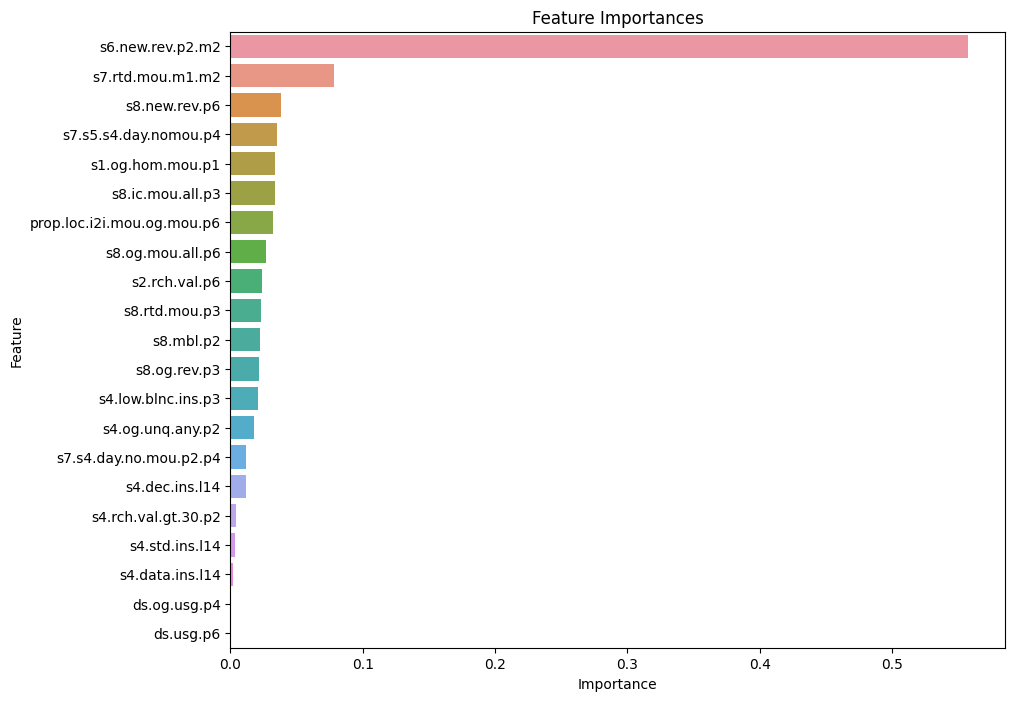

In [32]:
# Plot the feature importances
importances = best_clf.feature_importances_
feature_names = X.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importances')
plt.show()

***Logistic Regression***

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [35]:
# Initialize the Logistic Regression Classifier
clf = LogisticRegression(random_state=42, max_iter=10000)

In [36]:
# Set up the parameter grid for hyperparameter tuning
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear', 'saga'],
    'l1_ratio': [None, 0.15, 0.5, 0.85]
}

In [37]:
# Use RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, n_iter=50, cv=3, n_jobs=1, verbose=2, random_state=42)
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END .C=0.001, l1_ratio=0.85, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END .C=0.001, l1_ratio=0.85, penalty=none, solver=lbfgs; total time=   0.0s


c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)
c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)
c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and

[CV] END .C=0.001, l1_ratio=0.85, penalty=none, solver=lbfgs; total time=   0.1s
[CV] END ...C=1, l1_ratio=0.15, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...C=1, l1_ratio=0.15, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...C=1, l1_ratio=0.15, penalty=l1, solver=liblinear; total time=   0.0s


c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)
c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)
c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)
c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


[CV] END .C=100, l1_ratio=0.15, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .C=100, l1_ratio=0.15, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .C=100, l1_ratio=0.15, penalty=l2, solver=liblinear; total time=   0.0s


c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)
c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


[CV] END C=0.001, l1_ratio=0.85, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, l1_ratio=0.85, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, l1_ratio=0.85, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END ...C=1, l1_ratio=0.85, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...C=1, l1_ratio=0.85, penalty=l1, solver=liblinear; total time=   0.0s


c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)
c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)
c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)
c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"

[CV] END ...C=1, l1_ratio=0.85, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.001, l1_ratio=None, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END .C=0.001, l1_ratio=None, penalty=none, solver=lbfgs; total time=   0.0s


c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


[CV] END .C=0.001, l1_ratio=None, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, l1_ratio=0.85, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=0.001, l1_ratio=0.85, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=0.001, l1_ratio=0.85, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ....C=1, l1_ratio=0.5, penalty=l2, solver=liblinear; total time=   0.0s


c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)
c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


[CV] END ....C=1, l1_ratio=0.5, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ....C=1, l1_ratio=0.5, penalty=l2, solver=liblinear; total time=   0.0s


c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


[CV] END ......C=0.01, l1_ratio=0.5, penalty=l2, solver=saga; total time=   0.1s
[CV] END ......C=0.01, l1_ratio=0.5, penalty=l2, solver=saga; total time=   0.1s


c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)
c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


[CV] END ......C=0.01, l1_ratio=0.5, penalty=l2, solver=saga; total time=   0.1s
[CV] END ......C=10, l1_ratio=None, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ......C=10, l1_ratio=None, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ......C=10, l1_ratio=None, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=10, l1_ratio=0.5, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=10, l1_ratio=0.5, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=10, l1_ratio=0.5, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END ..C=0.001, l1_ratio=0.5, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ..C=0.001, l1_ratio=0.5, penalty=none, solver=lbfgs; total time=   0.0s


c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)
c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)
c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and

[CV] END ..C=0.001, l1_ratio=0.5, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=0.1, l1_ratio=0.15, penalty=elasticnet, solver=saga; total time=   0.2s
[CV] END C=0.1, l1_ratio=0.15, penalty=elasticnet, solver=saga; total time=   0.1s
[CV] END C=0.1, l1_ratio=0.15, penalty=elasticnet, solver=saga; total time=   0.1s
[CV] END .....C=100, l1_ratio=0.85, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END .....C=100, l1_ratio=0.85, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END .....C=100, l1_ratio=0.85, penalty=l2, solver=lbfgs; total time=   0.0s


c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)
c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)
c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


[CV] END C=0.01, l1_ratio=None, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=0.01, l1_ratio=None, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=0.01, l1_ratio=None, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END .......C=10, l1_ratio=0.5, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .......C=10, l1_ratio=0.5, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .......C=10, l1_ratio=0.5, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....C=0.001, l1_ratio=None, penalty=l2, solver=saga; total time=   0.1s
[CV] END ....C=0.001, l1_ratio=None, penalty=l2, solver=saga; total time=   0.1s
[CV] END ....C=0.001, l1_ratio=None, penalty=l2, solver=saga; total time=   0.1s
[CV] END C=10, l1_ratio=0.5, penalty=elasticnet, solver=saga; total time=   0.4s
[CV] END C=10, l1_ratio=0.5, penalty=elasticnet, solver=saga; total time=   0.2s
[CV] END C=10, l1_ratio=0.5, penalty=elasticnet, solver=saga; total time=   0.1s
[CV] END ....C=10, 

c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)
c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)
c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and

[CV] END .....C=0.01, l1_ratio=0.5, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END .....C=0.01, l1_ratio=0.5, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END .....C=0.01, l1_ratio=0.5, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ......C=100, l1_ratio=0.5, penalty=l2, solver=lbfgs; total time=   0.0s


c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)
c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)
c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)
c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


[CV] END ......C=100, l1_ratio=0.5, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ......C=100, l1_ratio=0.5, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ....C=0.01, l1_ratio=0.85, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....C=0.01, l1_ratio=0.85, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....C=0.01, l1_ratio=0.85, penalty=l1, solver=lbfgs; total time=   0.0s


c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)
c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


[CV] END ......C=0.1, l1_ratio=0.15, penalty=l2, solver=saga; total time=   0.1s


c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


[CV] END ......C=0.1, l1_ratio=0.15, penalty=l2, solver=saga; total time=   0.1s


c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


[CV] END ......C=0.1, l1_ratio=0.15, penalty=l2, solver=saga; total time=   0.1s
[CV] END C=100, l1_ratio=0.85, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=100, l1_ratio=0.85, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=100, l1_ratio=0.85, penalty=none, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, l1_ratio=0.5, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, l1_ratio=0.5, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, l1_ratio=0.5, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=100, l1_ratio=None, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=100, l1_ratio=None, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=100, l1_ratio=None, penalty=none, solver=liblinear; total time=   0.0s


c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)
c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)
c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)


[CV] END C=0.1, l1_ratio=0.85, penalty=elasticnet, solver=saga; total time=   0.1s
[CV] END C=0.1, l1_ratio=0.85, penalty=elasticnet, solver=saga; total time=   0.2s
[CV] END C=0.1, l1_ratio=0.85, penalty=elasticnet, solver=saga; total time=   0.2s
[CV] END .......C=1, l1_ratio=None, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END .......C=1, l1_ratio=None, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END .......C=1, l1_ratio=None, penalty=l2, solver=lbfgs; total time=   0.0s


c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)
c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)
c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


[CV] END .....C=0.1, l1_ratio=0.15, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END .....C=0.1, l1_ratio=0.15, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END .....C=0.1, l1_ratio=0.15, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ....C=0.01, l1_ratio=0.15, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....C=0.01, l1_ratio=0.15, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....C=0.01, l1_ratio=0.15, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ......C=0.1, l1_ratio=None, penalty=l2, solver=saga; total time=   0.1s
[CV] END ......C=0.1, l1_ratio=None, penalty=l2, solver=saga; total time=   0.1s
[CV] END ......C=0.1, l1_ratio=None, penalty=l2, solver=saga; total time=   0.1s


c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


[CV] END ........C=1, l1_ratio=0.85, penalty=l2, solver=saga; total time=   0.1s
[CV] END ........C=1, l1_ratio=0.85, penalty=l2, solver=saga; total time=   0.1s


c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)
c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


[CV] END ........C=1, l1_ratio=0.85, penalty=l2, solver=saga; total time=   0.2s
[CV] END .C=1, l1_ratio=None, penalty=none, solver=liblinear; total time=   0.0s
[CV] END .C=1, l1_ratio=None, penalty=none, solver=liblinear; total time=   0.0s
[CV] END .C=1, l1_ratio=None, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=10, l1_ratio=0.85, penalty=elasticnet, solver=saga; total time=   0.2s
[CV] END C=10, l1_ratio=0.85, penalty=elasticnet, solver=saga; total time=   0.1s
[CV] END C=10, l1_ratio=0.85, penalty=elasticnet, solver=saga; total time=   0.1s
[CV] END .......C=1, l1_ratio=0.85, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END .......C=1, l1_ratio=0.85, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END .......C=1, l1_ratio=0.85, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ........C=1, l1_ratio=0.5, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ........C=1, l1_ratio=0.5, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ........C=1, l1_

c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)
c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)
c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)
c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


[CV] END ......C=10, l1_ratio=0.85, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ......C=10, l1_ratio=0.85, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ......C=10, l1_ratio=0.85, penalty=l2, solver=lbfgs; total time=   0.0s


c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)
c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)
c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)
c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameter

[CV] END ....C=0.1, l1_ratio=0.85, penalty=none, solver=saga; total time=   0.1s
[CV] END ....C=0.1, l1_ratio=0.85, penalty=none, solver=saga; total time=   0.1s


c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)
c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)
c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and

[CV] END ....C=0.1, l1_ratio=0.85, penalty=none, solver=saga; total time=   0.2s
[CV] END C=10, l1_ratio=None, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=10, l1_ratio=None, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=10, l1_ratio=None, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ...C=0.1, l1_ratio=0.15, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ...C=0.1, l1_ratio=0.15, penalty=none, solver=lbfgs; total time=   0.0s


c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)
c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)
c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and

[CV] END ...C=0.1, l1_ratio=0.15, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END .....C=1, l1_ratio=0.15, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END .....C=1, l1_ratio=0.15, penalty=none, solver=lbfgs; total time=   0.0s


c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)
c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)
c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)


[CV] END .....C=1, l1_ratio=0.15, penalty=none, solver=lbfgs; total time=   0.1s


c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)


[CV] END ......C=100, l1_ratio=0.15, penalty=l1, solver=saga; total time=   0.3s


c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)


[CV] END ......C=100, l1_ratio=0.15, penalty=l1, solver=saga; total time=   0.2s


c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)


[CV] END ......C=100, l1_ratio=0.15, penalty=l1, solver=saga; total time=   0.2s
[CV] END ......C=1, l1_ratio=None, penalty=none, solver=saga; total time=   0.1s
[CV] END ......C=1, l1_ratio=None, penalty=none, solver=saga; total time=   0.1s
[CV] END ......C=1, l1_ratio=None, penalty=none, solver=saga; total time=   0.1s
[CV] END .....C=0.1, l1_ratio=0.85, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....C=0.1, l1_ratio=0.85, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....C=0.1, l1_ratio=0.85, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, l1_ratio=0.5, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, l1_ratio=0.5, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, l1_ratio=0.5, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, l1_ratio=0.15, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=0.001, l1_ratio=0.15, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C

c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)


[CV] END ........C=1, l1_ratio=0.15, penalty=l1, solver=saga; total time=   0.2s


c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)


[CV] END ........C=1, l1_ratio=0.15, penalty=l1, solver=saga; total time=   0.1s
[CV] END ........C=1, l1_ratio=0.15, penalty=l1, solver=saga; total time=   0.1s


c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)


[CV] END .......C=1, l1_ratio=None, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .......C=1, l1_ratio=None, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .......C=1, l1_ratio=None, penalty=l1, solver=lbfgs; total time=   0.0s


c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)


[CV] END ......C=1, l1_ratio=0.15, penalty=none, solver=saga; total time=   0.1s
[CV] END ......C=1, l1_ratio=0.15, penalty=none, solver=saga; total time=   0.1s


c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)
c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)


[CV] END ......C=1, l1_ratio=0.15, penalty=none, solver=saga; total time=   0.1s


c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
51 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\SaiAnkith\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\Users\SaiAnkith\AppData\Local\

RandomizedSearchCV(cv=3,
                   estimator=LogisticRegression(max_iter=10000,
                                                random_state=42),
                   n_iter=50, n_jobs=1,
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                                        'l1_ratio': [None, 0.15, 0.5, 0.85],
                                        'penalty': ['l1', 'l2', 'elasticnet',
                                                    'none'],
                                        'solver': ['lbfgs', 'liblinear',
                                                   'saga']},
                   random_state=42, verbose=2)

In [38]:
# Get the best estimator from the random search
best_clf = random_search.best_estimator_

In [39]:
# Make predictions on the test set
y_pred = best_clf.predict(X_test)

In [40]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Best Parameters:", random_search.best_params_)
print("Accuracy:", accuracy)
print("Classification Report:")
print(report)
print("Confusion Matrix:")
print(conf_matrix)

Best Parameters: {'solver': 'liblinear', 'penalty': 'l1', 'l1_ratio': 0.15, 'C': 1}
Accuracy: 0.795482546201232
Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.90      0.86      3365
         1.0       0.72      0.56      0.63      1505

    accuracy                           0.80      4870
   macro avg       0.77      0.73      0.74      4870
weighted avg       0.79      0.80      0.79      4870

Confusion Matrix:
[[3033  332]
 [ 664  841]]


***Random Forest***

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [42]:
# Initialize the Random Forest Classifier
clf = RandomForestClassifier(random_state=42)


In [43]:
# Set up the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [44]:
# Use RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, n_iter=50, cv=3, n_jobs=1, verbose=2, random_state=42)
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=  15.4s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=  22.4s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=  13.1s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; 

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=50, n_jobs=1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30, 40, 50],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=42, verbose=2)

In [45]:
# Get the best estimator from the random search
best_clf = random_search.best_estimator_

In [46]:
# Make predictions on the test set
y_pred = best_clf.predict(X_test)

In [47]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Best Parameters:", random_search.best_params_)
print("Accuracy:", accuracy)
print("Classification Report:")
print(report)
print("Confusion Matrix:")
print(conf_matrix)

Best Parameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 40, 'bootstrap': True}
Accuracy: 0.7919917864476386
Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.90      0.86      3365
         1.0       0.71      0.55      0.62      1505

    accuracy                           0.79      4870
   macro avg       0.77      0.72      0.74      4870
weighted avg       0.78      0.79      0.78      4870

Confusion Matrix:
[[3036  329]
 [ 684  821]]
